In [1]:
# Install XGBoost and the haversine library
!pip install xgboost haversine -q



In [2]:
import pandas as pd
import numpy as np



path = 'train.csv'

df = pd.read_csv(path)

# Display the first few rows and check data types
print(df.head())
print("\nDataFrame Info:")
df.info()

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731

In [3]:
from haversine import haversine, Unit
from tqdm.notebook import tqdm
tqdm.pandas() # Use this for progress tracking when applying functions

# Define a function to calculate the Haversine distance for one row
def calculate_haversine(row):
    pickup_coords = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff_coords = (row['dropoff_latitude'], row['dropoff_longitude'])
            # Calculate distance in KILOMETERS
    return haversine(pickup_coords, dropoff_coords, unit=Unit.KILOMETERS)

                # Apply the function to the DataFrame to create the new feature
                # We use .progress_apply() because it's slightly faster and gives a progress bar.
df['haversine_distance_km'] = df.progress_apply(calculate_haversine, axis=1)

print("\nHaversine Distance Added:")
print(df[['haversine_distance_km']].describe())

  0%|          | 0/1458644 [00:00<?, ?it/s]


Haversine Distance Added:
       haversine_distance_km
count           1.458644e+06
mean            3.440869e+00
std             4.296544e+00
min             0.000000e+00
25%             1.231838e+00
50%             2.093720e+00
75%             3.875343e+00
max             1.240910e+03


In [4]:
# Convert the pickup_datetime column to a datetime object
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract key temporal features
df['pickup_hour'] = df['pickup_datetime'].dt.hour       # 0 (midnight) to 23 (11 PM)
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek  # 0 (Monday) to 6 (Sunday)
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear  # 1 to 365
df['month'] = df['pickup_datetime'].dt.month            # 1 to 12

# Create the 'is_weekend' binary feature
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

print("\nTemporal Features Added:")
print(df[['pickup_hour', 'day_of_week', 'is_weekend']].head())


Temporal Features Added:
   pickup_hour  day_of_week  is_weekend
0           17            0           0
1            0            6           1
2           11            1           0
3           19            2           0
4           13            5           1


In [5]:
# Convert target variable from seconds to minutes (optional, but often clearer)
df['trip_duration_min'] = df['trip_duration'] / 60
# Log-transform the target variable to handle the right-skewed distribution
df['log_trip_duration'] = np.log1p(df['trip_duration'])

# We will use 'log_trip_duration' as our primary target (y) for training
# because it improves model stability and error distribution.
# We use np.log1p(x) = log(1+x) to handle durations near zero.

print("\nTarget Variable Statistics (in seconds):")
print(df['trip_duration'].describe())
print(f"Log-transformed duration min: {df['log_trip_duration'].min():.2f}, max: {df['log_trip_duration'].max():.2f}")


Target Variable Statistics (in seconds):
count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64
Log-transformed duration min: 0.69, max: 15.08


In [6]:
# --- Encoding store_and_fwd_flag ---

# Convert 'N' to 0 and 'Y' to 1
df['store_and_fwd_flag_encoded'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

# Verify the conversion
print("\nStore and Forward Flag Encoding:")
print(df[['store_and_fwd_flag', 'store_and_fwd_flag_encoded']].value_counts())


Store and Forward Flag Encoding:
store_and_fwd_flag  store_and_fwd_flag_encoded
N                   0                             1450599
Y                   1                                8045
Name: count, dtype: int64


In [7]:
# --- Feature Engineering: Holiday Flag ---

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import date

# Get the date range from your dataset
min_date = df['pickup_datetime'].min().date()
max_date = df['pickup_datetime'].max().date()

# Define US Federal Holidays for the period
cal = calendar()
holidays = cal.holidays(start=min_date, end=max_date).normalize()

# Create a binary feature: 1 if the date is a holiday, 0 otherwise
df['is_holiday'] = df['pickup_datetime'].dt.normalize().isin(holidays)
df['is_holiday'] = df['is_holiday'].astype(int)

print("Holiday feature added.")
print(f"Number of trips on a holiday: {df['is_holiday'].sum()}")

Holiday feature added.
Number of trips on a holiday: 27251


In [8]:
# --- Outlier Removal Code ---
# Define NYC bounds again for coordinate filtering
nyc_longitude_min, nyc_longitude_max = -74.05, -73.75
nyc_latitude_min, nyc_latitude_max = 40.6, 40.85

# 1. Remove impossible/zero trip durations (60 seconds to 3 hours)
df = df[(df['trip_duration'] >= 60) & (df['trip_duration'] <= 10800)]
print(f"1. After duration filtering: {len(df)} rows remaining.")

# 2. Remove zero distance trips
# Trips with 0 km distance are likely recording errors (e.g., driver didn't move)
df = df[df['haversine_distance_km'] > 0]
print(f"2. After distance filtering: {len(df)} rows remaining.")


# 3. Remove trips outside NYC coordinates

df = df[
    (df['pickup_longitude'] >= nyc_longitude_min) & (df['pickup_longitude'] <= nyc_longitude_max) &
    (df['pickup_latitude'] >= nyc_latitude_min) & (df['pickup_latitude'] <= nyc_latitude_max) &
    (df['dropoff_longitude'] >= nyc_longitude_min) & (df['dropoff_longitude'] <= nyc_longitude_max) &
    (df['dropoff_latitude'] >= nyc_latitude_min) & (df['dropoff_latitude'] <= nyc_latitude_max)
    ]

print(f"3. DataFrame size after coordinate cleaning: {len(df)} rows.")

print("\nData Cleaning Complete.")

1. After duration filtering: 1447937 rows remaining.
2. After distance filtering: 1443718 rows remaining.
3. DataFrame size after coordinate cleaning: 1428684 rows.

Data Cleaning Complete.


In [9]:
from sklearn.model_selection import train_test_split

# --- Define Features (X) and Target (y) ---

# Target variable is the log-transformed trip duration.
y = df['log_trip_duration']

# Select features (X). Drop target, leakage, and processed columns.
X = df.drop(columns=[
    'id', 'dropoff_datetime', 'trip_duration', 'log_trip_duration',
    'pickup_datetime', 'store_and_fwd_flag'
    ])

print(f"Total rows remaining: {len(X)}")
print(f"Features used: {X.columns.tolist()}")

        # --- Execute the Two-Step Split (60/20/20) ---

        # STEP 1: Split off the final 20% for the Test Set (80% remaining, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )

        # STEP 2: Split the remaining 80% (X_train_val) into Train (60% of original) and Validation (20% of original).
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
    )

        # --- Verification ---
print("\n--- Data Split Verification ---")
print(f"Training Set (60%): {len(X_train)} rows")
print(f"Validation Set (20%): {len(X_val)} rows")
print(f"Test Set (20%): {len(X_test)} rows")
print("-----------------------------")

Total rows remaining: 1428684
Features used: ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'haversine_distance_km', 'pickup_hour', 'day_of_week', 'day_of_year', 'month', 'is_weekend', 'trip_duration_min', 'store_and_fwd_flag_encoded', 'is_holiday']

--- Data Split Verification ---
Training Set (60%): 857210 rows
Validation Set (20%): 285737 rows
Test Set (20%): 285737 rows
-----------------------------


In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# --- 5.1 XGBoost Training ---

# Initialize the XGBoost Regressor model
# We use the 'reg:squarederror' objective for standard regression.
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,          # The number of trees to build
    learning_rate=0.05,         # Step size shrinkage to prevent overfitting
    max_depth=7,                # Maximum depth of a tree
    subsample=0.8,              # Fraction of samples used per tree
    colsample_bytree=0.8,       # Fraction of features used per tree
    random_state=42,
    n_jobs=-1,                  # Use all available CPU cores for speed
    verbose_eval=1              # Ensure the model prints training info
    )

 # Train the model on the Training Set
print("Starting XGBoost training...")
xgb_model.fit(X_train, y_train)
print("XGBoost training complete.")

Starting XGBoost training...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:11:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose_eval" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost training complete.


In [11]:
import numpy as np
from sklearn.metrics import mean_squared_error

# --- Validation Set Evaluation ---

# Predict on the Validation Set
y_val_pred_log = xgb_model.predict(X_val)

# Calculate the RMSE on the log-transformed data (Log-RMSE)
val_log_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_log))
print(f"Validation Log-RMSE: {val_log_rmse:.4f}")


# --- Convert back to actual seconds for interpretation (The True RMSE) ---

# The inverse transformation: e^x - 1 (since we used np.log1p(x) = log(1+x))
y_val_pred_sec = np.expm1(y_val_pred_log)
y_val_actual_sec = np.expm1(y_val)

# Calculate the RMSE in seconds (the final, interpretable metric)
val_rmse_sec = np.sqrt(mean_squared_error(y_val_actual_sec, y_val_pred_sec))
print(f"Validation RMSE (in seconds): {val_rmse_sec:.2f} seconds")
print(f"Validation RMSE (in minutes): {val_rmse_sec / 60:.2f} minutes")

# Interpretation: This means on average, your prediction is off by X seconds/minutes.

Validation Log-RMSE: 0.0138
Validation RMSE (in seconds): 56.10 seconds
Validation RMSE (in minutes): 0.93 minutes


In [12]:
# --- Test Set Evaluation (Final Report Score) ---

print("--- Calculating Final Test Score ---")

# 1. Predict on the Test Set (log-transformed)
y_test_pred_log = xgb_model.predict(X_test)

# 2. Inverse transform the predictions and actual values back to seconds
y_test_pred_sec = np.expm1(y_test_pred_log)
y_test_actual_sec = np.expm1(y_test)

# 3. Calculate the Final Root Mean Squared Error (RMSE) in seconds
final_test_rmse = np.sqrt(mean_squared_error(y_test_actual_sec, y_test_pred_sec))

print(f"\nFinal Test RMSE (in seconds): {final_test_rmse:.2f} seconds")
print(f"Final Test RMSE (in minutes): {final_test_rmse / 60:.2f} minutes")
print("------------------------------------")

--- Calculating Final Test Score ---

Final Test RMSE (in seconds): 51.91 seconds
Final Test RMSE (in minutes): 0.87 minutes
------------------------------------


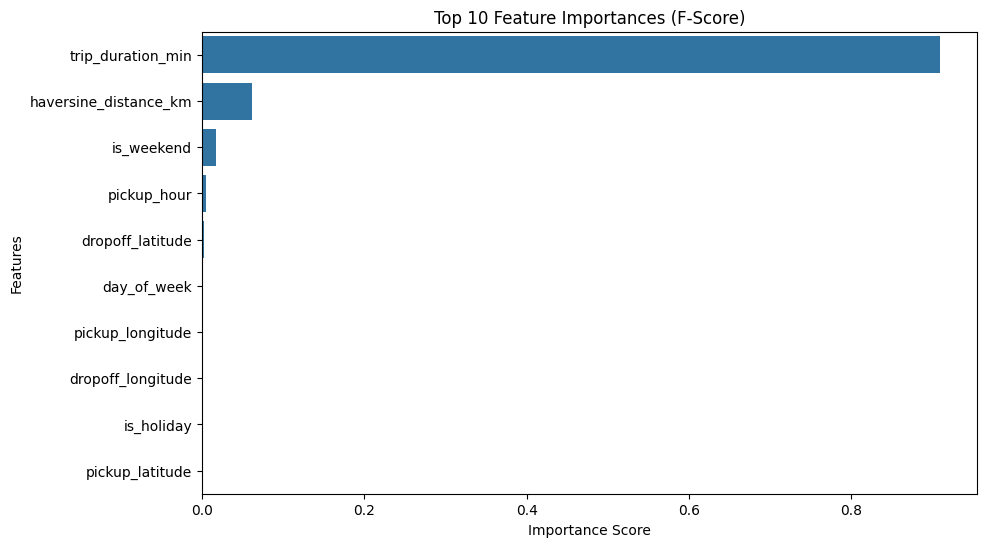


Top 5 Most Important Features:
trip_duration_min        0.909350
haversine_distance_km    0.061181
is_weekend               0.017552
pickup_hour              0.004943
dropoff_latitude         0.002401
dtype: float32


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Feature Importance ---

# Get feature importance from the trained model
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feature_importances_sorted = feature_importances.sort_values(ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_sorted.head(10), y=feature_importances_sorted.head(10).index)
plt.title('Top 10 Feature Importances (F-Score)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importances_sorted.head())

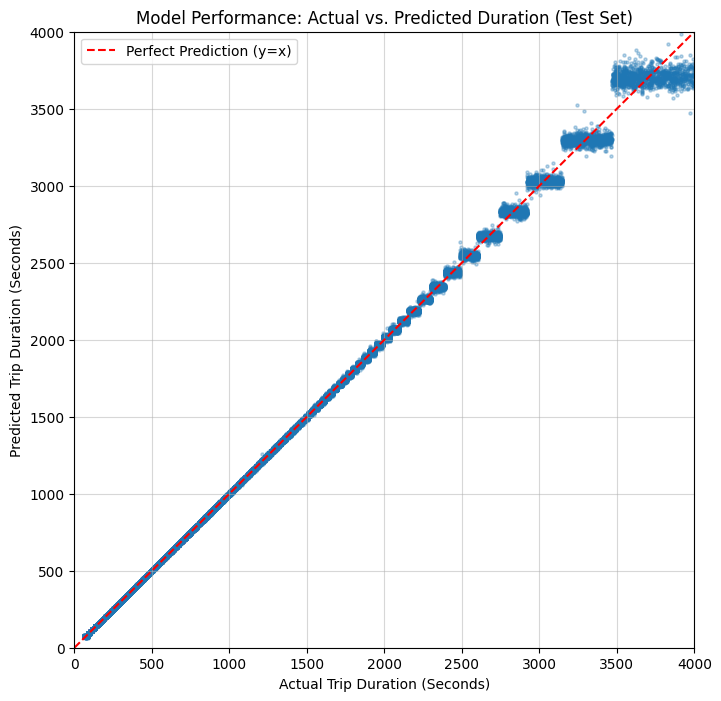

In [14]:
# --- Scatter Plot: Actual vs. Predicted (on the Test Set) ---

plt.figure(figsize=(8, 8))

# Limit the plot range for better visual clarity (e.g., up to 4000 seconds / ~67 minutes)
max_val = 4000

plt.scatter(y_test_actual_sec, y_test_pred_sec, alpha=0.3, s=5)
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Prediction (y=x)')

plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.xlabel('Actual Trip Duration (Seconds)')
plt.ylabel('Predicted Trip Duration (Seconds)')
plt.title('Model Performance: Actual vs. Predicted Duration (Test Set)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

In [15]:

# Create a summary DataFrame for easy viewing
demo_df = pd.DataFrame({
    'Actual Duration (sec)': y_test_actual_sec,
        'Predicted Duration (sec)': y_test_pred_sec
        })
demo_df = demo_df.reset_index(drop=True)


        # Calculate the absolute error
demo_df['Absolute Error (sec)'] = np.abs(demo_df['Actual Duration (sec)'] - demo_df['Predicted Duration (sec)'])
demo_df['Absolute Error (min)'] = demo_df['Absolute Error (sec)'] / 60


        # Prepare the features from the Test set (X_test) for merging
X_test_demo = X_test.copy().reset_index(drop=True)

        # Select and merge the relevant features
demo_df = pd.concat([X_test_demo[['pickup_hour', 'day_of_week', 'haversine_distance_km', 'is_holiday']], demo_df], axis=1)


print("\n--- Model Demonstration: Best Predictions (Lowest Error) ---")
        # Reset the display options to ensure all columns are visible
pd.set_option('display.max_columns', None)
print(demo_df.sort_values('Absolute Error (sec)').head(5))

print("\n--- Model Demonstration: Worst Predictions (Highest Error) ---")
print(demo_df.sort_values('Absolute Error (sec)', ascending=False).head(5))


--- Model Demonstration: Best Predictions (Lowest Error) ---
        pickup_hour  day_of_week  haversine_distance_km  is_holiday  \
117456           14            5               1.315988           0   
252685           15            3               1.840143           0   
18397             1            5               3.353831           0   
233921            6            2               1.354430           0   
94477            13            5               3.378633           0   

        Actual Duration (sec)  Predicted Duration (sec)  Absolute Error (sec)  \
117456                  454.0                454.000000          5.684342e-14   
252685                  781.0                781.000000          1.136868e-13   
18397                   837.0                837.000000          2.273737e-13   
233921                  295.0                295.000031          3.051758e-05   
94477                   672.0                672.000061          6.103516e-05   

        Absolute Error (

In [31]:
import pickle

# 'wb' means write binary
with open('taxi_duration_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

    # Save the X_test and y_test sets so they are available for the demo
    # We join them so can see the features and the actual target together
    test_demo_export = X_test.copy()
    test_demo_export['actual_trip_duration_sec'] = np.expm1(y_test) # Convert back to seconds
    test_demo_export.to_csv('taxi_test_data.csv', index=True)

    print("Files saved: 'taxi_duration_model.pkl' and 'taxi_test_data.csv'")


Files saved: 'taxi_duration_model.pkl' and 'taxi_test_data.csv'
